In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
tf.__version__

2023-01-25 19:46:55.808065: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


'2.9.1'

In [3]:
from tensorflow import keras

In [4]:
from tensorflow.keras.preprocessing.image import load_img

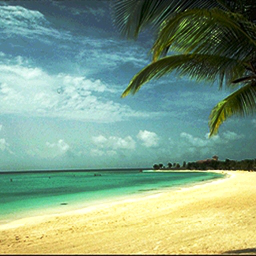

In [5]:
data_dir_path = "data/"
test_coast_dir_path = data_dir_path + "test/coast/"
file_path = test_coast_dir_path + "b_beach_coast_bea10.jpg"
load_img(file_path)

In [6]:
img = load_img(file_path)
x = np.array(img)
x.shape

(256, 256, 3)

## Train Xception for scene classification of 3 types of scenaries: coast, forest, mountain

In [7]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# specify the data directory paths
train_dir = "data/train"
val_dir = "data/validation"
test_dir = "data/test"

In [9]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32
)

Found 928 images belonging to 3 classes.


In [10]:
train_ds.class_indices

{'coast': 0, 'forest': 1, 'mountain': 2}

In [11]:
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    shuffle=False
)

Found 115 images belonging to 3 classes.


In [12]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(3)(vectors)

model = keras.Model(inputs, outputs)

2023-01-25 19:52:14.122492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:52:14.129874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:52:14.131128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 19:52:14.132370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

83683744/83683744 [==============================] - 3s 0us/step


In [13]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

loss = keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [14]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


2023-01-25 19:52:38.866862: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-25 19:52:39.484391: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-25 19:52:39.485311: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-25 19:52:39.485348: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-25 19:52:39.486235: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-25 19:52:39.486306: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


29/29 [==============================] - 9s 146ms/step - loss: 0.2248 - accuracy: 0.9483 - val_loss: 0.0418 - val_accuracy: 0.9826
Epoch 2/10
29/29 [==============================] - 3s 98ms/step - loss: 0.0578 - accuracy: 0.9817 - val_loss: 0.0419 - val_accuracy: 0.9739
Epoch 3/10
29/29 [==============================] - 3s 97ms/step - loss: 0.0247 - accuracy: 0.9925 - val_loss: 0.0172 - val_accuracy: 1.0000
Epoch 4/10
29/29 [==============================] - 3s 98ms/step - loss: 0.0115 - accuracy: 0.9978 - val_loss: 0.0177 - val_accuracy: 0.9913
Epoch 5/10
29/29 [==============================] - 3s 99ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 6/10
29/29 [==============================] - 3s 98ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 7/10
29/29 [==============================] - 3s 100ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 8/10
29/29 [====

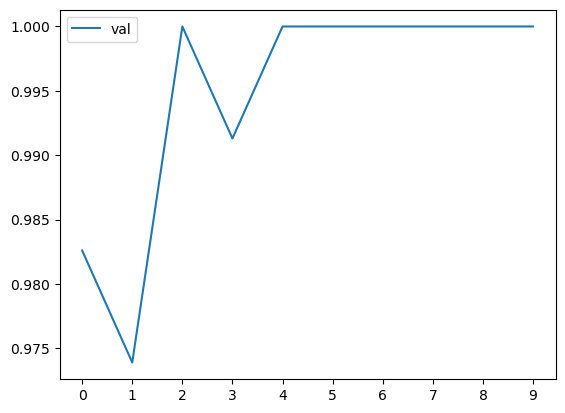

In [15]:
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

The validation accuracy is very good and it took only 4 epochs of training to reach 100% accuracy.  However, Xception is a big model (22.9M parameters). Next, we will experiment with MobileNet, a lighter and faster model (4.3M parameters) and we will see that the performance (accuracy) of the lighter model is only slightly worse than Xception.  So MobileNet is able to achieve a good tradeoff among accuracy, speed and model size for our application.